In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

The data

The files station_locs.pt and weather_data.pt contain the location and temperature information in 339 weather stations in North America. The data was obtained from NOAA.
The complete package can be found in
https://github.com/meteostat/meteostat-python

We will use this data to analyze weather patterns and predictions. In the next cell we download and plot the data.

The data has 10 different columns:

'tavg' = Average  temp

'tmin' = Min  temp

'tmax' = Max  temp

'prcp' = Precipitation

'snow' = Snow

'wdir' = Wind direction

'wspd' = Wind Speed

'wpgt' = The dew point in °C  

'pres' = The average sea-level air pressure in hPa

'tsun' = The one hour sunshine total in minutes (m)



<ipython-input-9-46867d27dd0c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Data = torch.load('weather_data.pt')
<ipython-input-9-46867d27dd0c>:2: FutureWarning: You are

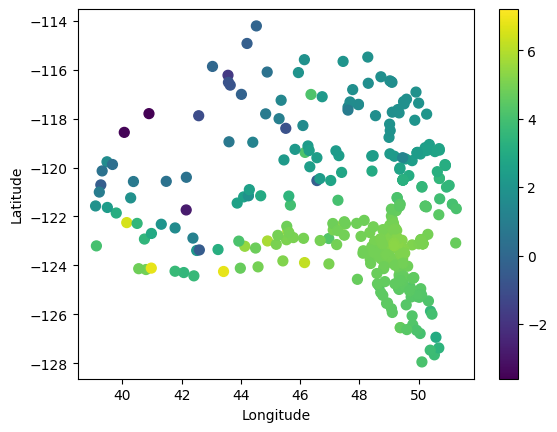

In [9]:
Data = torch.load('weather_data.pt')
station_locs = torch.load('station_locs.pt')

# Plot the avg temperature for the 0th date
map = Data[0,:,0] #selects data for first date, all stations, first weather measurement (avg temp)
plt.scatter(station_locs[:,0], station_locs[:,1], c=map, cmap='viridis',s=50)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()


INDEX ERROR(?)

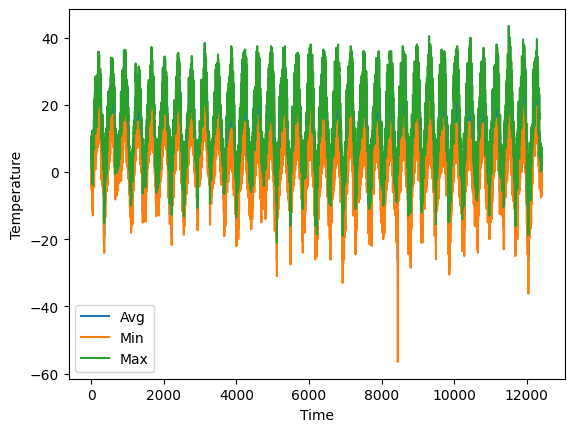

In [20]:
# plot the time series for the temperature at the first station
  # Data[time points, weather station, avg temperature, ...]
#plt.plot(Data[:,0,0]) #all time points, first station, and first column (avg temp)
#plt.plot(Data[:,1,0]) # plots avg temp recorded by second station over time
#plt.plot(Data[:,2,0]) # '' for third station
plt.plot(Data[:,0,0]) #all time points, first station, avg temp
plt.plot(Data[:,0,1]) # plots min temp for second station over time
plt.plot(Data[:,0,2]) # plots max temp for third station over time

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(['Avg','Min','Max'])

**Questions 1-2**

1. Use the scatter plot similar to the one above to plot the pressure map in all stations

2. Plot a time series for the pressure at station 0 over time - The data has a clear problem. Can you identify a problem with the data?



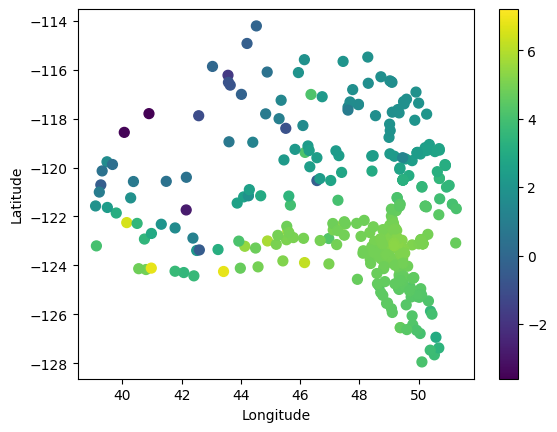

In [22]:
# Your code here
pressure = Data[:,0,8]

# Plot pressure map for all stations
pressure = Data[:,0,8] # pressure data on first day from all stations
plt.scatter(station_locs[:,0], station_locs[:,1], c=map, cmap='viridis',s=50)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()


Text(0, 0.5, 'Pressure')

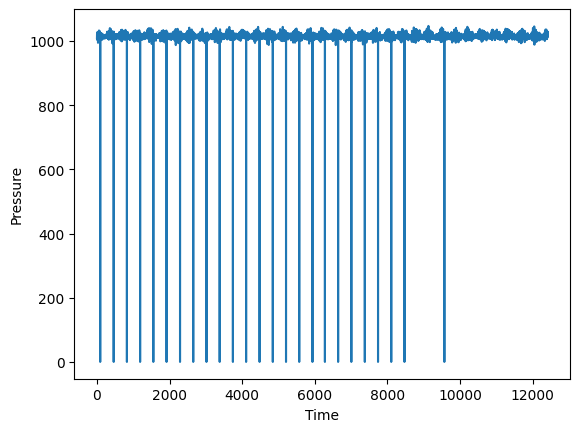

In [24]:
# time series for the pressure at station 0 over time
plt.plot(Data[:,0,8]) #all time points, first station, pressure

plt.xlabel('Time')
plt.ylabel('Pressure')

# observe data error <- atmospheric P rarely drops to zero at sea lvl

We are going to solve the problem with the data by changing the data in the problematic locations.
First, we identify the spots in the vector that are problematic. We then replace them with an average of their neiboughrs

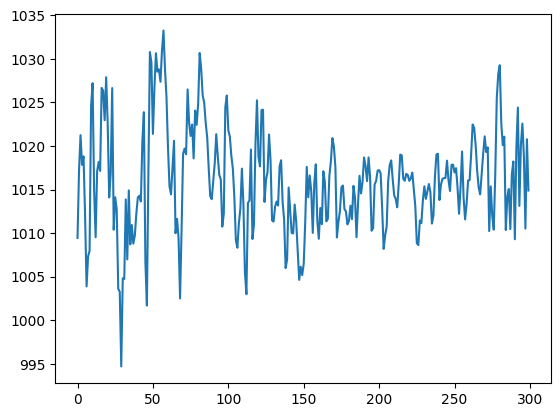

In [ ]:
ind = torch.where(pressure==0)[0] # stores indices where pressure is 0
pressure[ind] = (pressure[ind+1] + pressure[ind-1])/2 # replaces ind values with avg neighbor values
plt.plot(pressure[:300]) # plots first 300 points

**Question 3**

Reorganize the pressure as a matrix of 365 (days) and 34 years. Average over the days of the year and plot a graph of the average pressure over the years.
Is the pressure increasing/decreasing or inconclusive

Text(0, 0.5, 'Average Pressure')

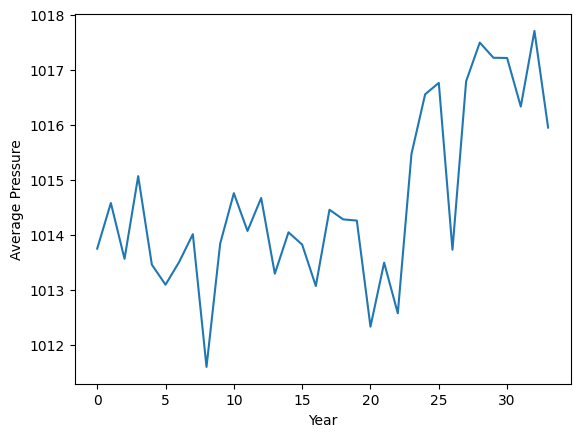

In [37]:
# 1) reorganize pressure as a matrix
  # a) extract pressure data from Data tensor (1D)
pressure_data = Data[:,0,8]
  # b) convert into a matrix (2D)and reshape into 34 years x 365 days
    # consider leap years therefore correct for missing steps
num_years = pressure_data.shape[0] // 365 # divide time steps into years
pressure_data = pressure_data[:num_years * 365] # trim to length (convert num_years (now divisible) -> days)
pressure_matrix = pressure_data.reshape(num_years, 365) # .reshape(rows, columns)
    # num_years: 34

# 2) average over the days of the year
avg_yearly_pressure = pressure_matrix.mean(axis=1) # calc avg pressure for each row where axis=0 is columns, axis=1 is rows, and axis=2 is depth (3D arrays)

# 3) plot graph of average pressure over the years
plt.plot(avg_yearly_pressure)
plt.xlabel('Year')
plt.ylabel('Average Pressure')

**Linear Models for the Temp**

Let us extract a part of the temperature and see if we can model it


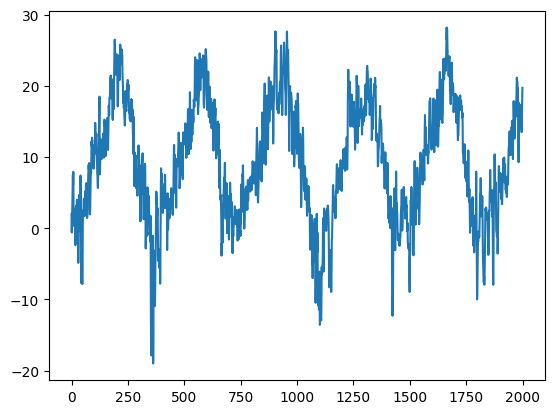

In [49]:
Temp = Data[:2000,0,0]
plt.plot(Temp)


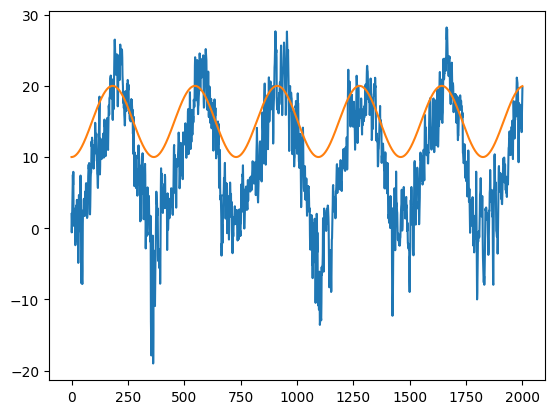

In [ ]:
# We now want to approximate the data with the model
t = np.linspace(0,2000,2000) # stores sequence of evenly-spaced numbers 0-2000
L = 365
a = np.array([0,0,20.0,10.0]) # stores initial coefficients for approx. model
Tapprox = a[0] + a[1]*t + a[2]*np.sin(t/L*np.pi)**2 + a[3]*np.cos(t/L*np.pi)**2
  # model includes linear and periodic oscillations to approx. temp data
plt.plot(t,Temp) # plots data
plt.plot(t,Tapprox) # plots model



**Questions 4**

4. The model above is a linear model in the coefficients
a[0] to a[3]
Use the least squares formulation and find the optimal coefficients. Plot the resulting fit.

theta =  [ 0.  0. 20. 10.]
r =  []
residuals =  tensor([ -7.9947, -10.5873,  -9.4866,  ...,  -3.5836,  -2.2254,  -0.2380],
       dtype=torch.float64)


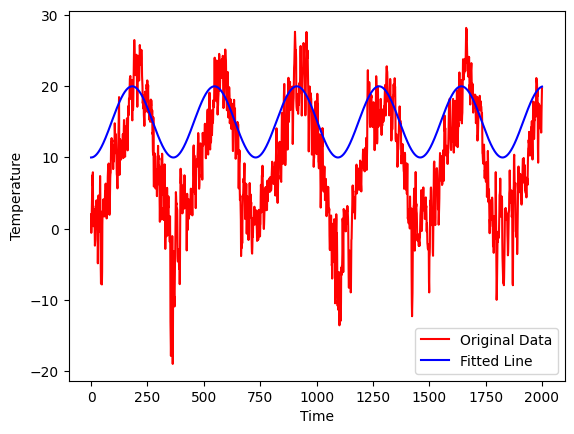

In [66]:
Temp = Data[:2000,0,0]

# og linear model
t = np.linspace(0,2000,2000) # stores sequence of evenly-spaced numbers 0-2000
L = 365
a = np.array([0,0,20.0,10.0]) # stores initial coefficients for approx. model
Tapprox = a[0] + a[1]*t + a[2]*np.sin(t/L*np.pi)**2 + a[3]*np.cos(t/L*np.pi)**2

# new linear model
# 1) formulate least squares by minimizing ||Temp - Tapprox||^2
# 2) solve for optimal coefficients with a = (X^T X)^-1 X^T Temp
A = np.vstack((np.ones(len(t)), t, np.sin(t/L*np.pi)**2, np.cos(t/L*np.pi)**2)).T  # Design matrix for linear model (indepedent variable t)
b = Temp  # Target vector

# Solve for the coefficients
output = np.linalg.lstsq(A, b, rcond=None)

# Print the coefficients and residuals
print('theta = ', a)
print('r = ', output[1])  # Sum of squared residuals
print('residuals = ', b - A @ a)

# Plot original data and fitted line
plt.plot(t, b, 'r-', label='Original Data')
plt.plot(t, A @ a, 'b-', label='Fitted Line')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()


**Question 5-7**
5. We have a second model we want to use. It as the form
$$ T = a_0 + a_1t + a_2t^2 + a_3 |\sin(\pi/L t)| + a_ |\sin(2 \pi/L t)| + a_5 |\sin(3\pi/L t)| $$  

Setup a least square problem for the model and solve for the coefficients. Plot the solution.

6. Plot the data and the solution obtained by both models.

7. (Open discussion) Given the 2 models, which model you think is better? Why?


In [ ]:
Temp = Data[:2000,0,0]

t = np.linspace(0,2000,2000) # stores sequence of evenly-spaced numbers 0-2000
L = 365
a = np.array([0,0,20.0,10.0]) # stores initial coefficients for approx. model
Tapprox2 = a[0] + a[1]*t + a[2]*t^2 + a[3]*np.sin(np.pi/L*t) + a[4]*np.sin(2*np.pi/L*t) + a[5]*np.sin(3*np.pi/L*t)|

A = np.vstack((np.ones(len(t)), t, np.sin(t/L*np.pi)**2, np.cos(t/L*np.pi)**2)).T  # Design matrix for linear model (indepedent variable t)
b = Temp  # Target vector

# Solve for the coefficients
output = np.linalg.lstsq(A, b, rcond=None)

# Print the coefficients and residuals
print('theta = ', a)
print('r = ', output[1])  # Sum of squared residuals
print('residuals = ', b - A @ a)

# Plot original data and fitted line
plt.plot(t, b, 'r-', label='Original Data')
plt.plot(t, A @ a, 'b-', label='Fitted Line')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()
